In [ ]:
!pip install torchquantum

In [ ]:
import numpy as np
import torch
import torchquantum as tq

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchquantum.functional import func_name_dict

import os
import random

import numpy as np
import pandas as pd

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
dataframe = pd.read_csv('twitter_dataset.csv')
df = dataframe.copy()
df

# Lets find out how many words are present in a single Speech!
df['word_counts'] = df['Speech'].apply(lambda x: len(x.split()))
df

,Label,Speech,word_counts
0,1,""" Keeks is a bitch she curves everyone "" lol I...",18
1,1,""" Murda Gang bitch its Gang Land """,8
2,1,""" So hoes that smoke are losers ? "" yea ... go...",14
3,1,""" bad bitches is the only thing that i like """,11
4,1,""" bitch get up off me """,7
...,...,...,...
109,0,I'm so proud of my fellow activists who are fi...,19
110,0,Thanks to all the creators who are sharing the...,21
111,0,I'm grateful for the diversity of voices and p...,19
112,0,Sending virtual hugs to anyone who needs one t...,14


In [ ]:
def clean_text(df):
    all_comments = list()
    lines = df.Speech.values.tolist()
    for text in lines:

        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        # removing #mentions
        text = re.sub(r"@+","", text)

        text = re.sub(r"[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~।ঃ\t\n]", "", text) # removing punctuations
        tokens = word_tokenize(text)

        stop_words = set(stopwords.words("english"))
        words = [w for w in tokens if not w in stop_words] # removing stop words

        words = ' '.join(words)
        all_comments.append(words)

    return all_comments

all_comments = clean_text(df)

df['process_speech'] = all_comments

In [ ]:
df.isnull().sum()

X = df.process_speech
Y = df.Label.values

## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(min_df=5, ngram_range=(1,2))
X = tfidf_v.fit_transform(X).toarray()

validation_split = 0.3

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

# 0.3 * 300 = 90
num_validation_samples = int(validation_split * X.shape[0])


X_train = X[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_test = X[-num_validation_samples:]
y_test = Y[-num_validation_samples:]

print(X_train)
print(y_train)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.72102491 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.8692389 ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0
 1 1 0 0 1 1]


#QSVM


In [ ]:
# pip install version_check
!pip install Pennylane

In [ ]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

from imblearn.over_sampling import SMOTE

import pandas as pd
import pennylane as qml
import numpy as np
from sklearn.model_selection import train_test_split # data split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt


In [ ]:
#QUANTUM LAYER
"""We make a quantum layer using Pennylane."""

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

"""For the QNode to be successfully converted to a layer in Keras, we need to
provide the details of the shape of each trainable weight for them to be initialized.
The ``weight_shapes`` dictionary maps from the argument names of the QNode to corresponding shapes"""
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
print("Quantum layer created")
#%% CLASSICAL LAYERS + INTEGRATE
# Create CLASSICAL layers

tf.keras.backend.set_floatx('float64')

model=Sequential() #create model

#add layers to our hybrid model
#activation parameters chosen arbitrarily - look into this!
model.add(Dense(units=2, activation='swish'))
model.add(qlayer)
model.add(Dense(units=1,activation='sigmoid')) #Sigmoid is equivalent to a 2-element Softmax,
#where the second element is assumed to be zero. The sigmoid function always returns a value between 0 and 1.
print("Quantum and classical layers added")

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(opt, loss="mae", metrics=["accuracy"])



# history = model.fit(X_train, y_train, batch_size = 2, epochs = 1,validation_split=0.2)
history = model.fit(X_train, y_train)
predictions = model.predict(X_test)


Quantum layer created
Quantum and classical layers added


1/3 [=========>....................] - ETA: 1s - loss: 0.4160 - accuracy: 0.8125

2/3 [===================>..........] - ETA: 0s - loss: 0.4148 - accuracy: 0.8125

2/2 [==============================] - 0s 99ms/step


# QML (Quantum Machine Learning)

In [ ]:
class KernalAnsatz(tq.QuantumModule):
    def __init__(self, func_list):
        super().__init__()
        self.func_list = func_list

    @tq.static_support
    def forward(self, q_device: tq.QuantumDevice, x, y):
        self.q_device = q_device
        self.q_device.reset_states(x.shape[0])
        for info in self.func_list:
            if tq.op_name_dict[info['func']].num_params > 0:
                params = x[:, info['input_idx']]
            else:
                params = None
            func_name_dict[info['func']](
                self.q_device,
                wires=info['wires'],
                params=params,
            )
        for info in reversed(self.func_list):
            if tq.op_name_dict[info['func']].num_params > 0:
                params = -y[:, info['input_idx']]
            else:
                params = None
            func_name_dict[info['func']](
                self.q_device,
                wires=info['wires'],
                params=params,
            )

In [ ]:
class Kernel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.ansatz = KernalAnsatz(
        [   {'input_idx': [0], 'func': 'ry', 'wires': [0]},
            {'input_idx': [1], 'func': 'ry', 'wires': [1]},
            {'input_idx': [2], 'func': 'ry', 'wires': [2]},
            {'input_idx': [3], 'func': 'ry', 'wires': [3]},])

    def forward(self, x, y, use_qiskit=False):
        # bsz=1
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        self.ansatz(self.q_device, x, y)
        result = torch.abs(self.q_device.states.view(-1)[0])
        return result

In [ ]:
kernel_function = Kernel()
def kernel_matrix(A, B):
    return np.array([[kernel_function(a, b) for b in B] for a in A])

qsvm = SVC(kernel=kernel_matrix, probability=True).fit(X_train, y_train)
predictions = qsvm.predict(X_test)

# Accuracy
print(accuracy_score(predictions, y_test))     # 2m 5 sec Executiion time

# Precision
# print(precision_score(y_test, predictions))

0.6470588235294118


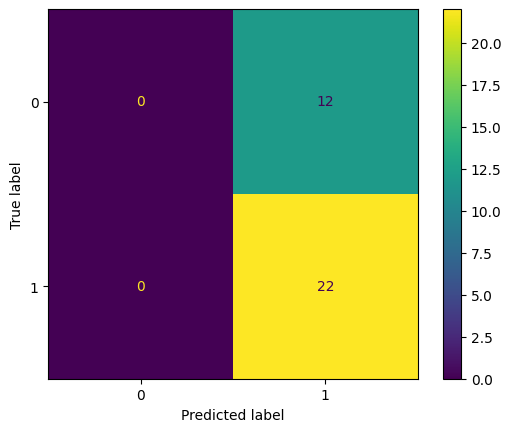

Precision: 0.419
Recall: 0.647
Accuracy: 0.647
F1 Score: 0.786


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import sklearn.metrics
# Function created to calculate confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_confusion_matrix(model):
  predictions = model.predict(X_test)
  cm = confusion_matrix(y_test, predictions, labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

  disp.plot()
  plt.show()

  # precision = sklearn.metrics.precision_score(y_train, y_test, pos_label="positive")
  # print(precision)
  y_pred = model.predict(X_test)
  print('Precision: %.3f' % precision_score(y_test, y_pred, average='weighted'))
  print('Recall: %.3f' % recall_score(y_test, y_pred, average='weighted'))
  print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
  print('F1 Score: %.3f' % f1_score(y_test, y_pred))

  # # predict probabilities
  # probs = model.predict_proba(X_test)
  # # keep probabilities for the positive outcome only
  # probs = probs[:, 1]

  # auc = roc_auc_score(y_test, probs)
  # print('AUC - Test Set: %.2f%%' % (auc*100))
calculate_confusion_matrix(qsvm)

#CLASSICAL MODELS

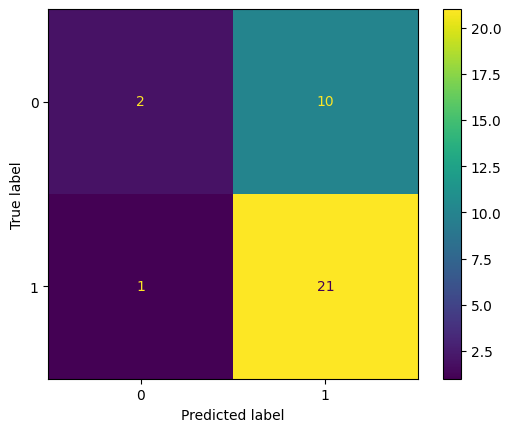

Precision: 0.674
Recall: 0.676
Accuracy: 0.676
F1 Score: 0.792


In [ ]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_train, y_train)
calculate_confusion_matrix(lg)

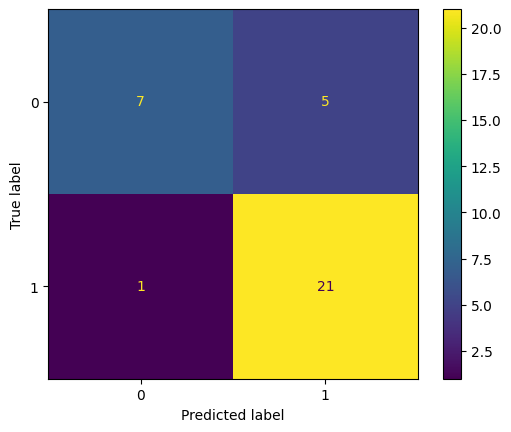

Precision: 0.831
Recall: 0.824
Accuracy: 0.824
F1 Score: 0.875


In [ ]:
from sklearn.svm import LinearSVC, SVC
lSVC = LinearSVC(random_state=0)
lSVC.fit(X_train, y_train)
calculate_confusion_matrix(lSVC)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle

# Generate a synthetic dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=4, n_informative=2, n_classes=2, random_state=42)
X, y = shuffle(X, y, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pegasos QSVC using SGDClassifier
pegasos_qsvc = SGDClassifier(loss='hinge', alpha=0.01, max_iter=1000, l1_ratio=0.1, random_state=42)
pegasos_qsvc.fit(X_train, y_train)

# Evaluate the model
y_pred = pegasos_qsvc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.845


#**PEGASOS** QSVC

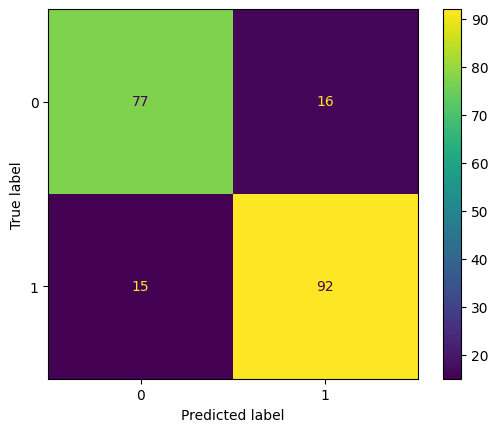

Precision: 0.852
Recall: 0.860
Accuracy: 0.845
F1 Score: 0.856


In [ ]:

# Function to calculate confusion matrix and evaluation metrics
def calculate_confusion_matrix(model, X_test, y_test):
    predictions = model.predict(X_test)

    # Convert multiclass target labels to binary (0 or 1)
    y_test_binary = convert_to_binary(y_test, positive_class=1)
    predictions_binary = convert_to_binary(predictions, positive_class=1)

    cm = confusion_matrix(y_test_binary, predictions_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('Precision: %.3f' % precision_score(y_test_binary, predictions_binary))
    print('Recall: %.3f' % recall_score(y_test_binary, predictions_binary))
    print('Accuracy: %.3f' % accuracy_score(y_test_binary, predictions_binary))
    print('F1 Score: %.3f' % f1_score(y_test_binary, predictions_binary))


# Calculate confusion matrix and evaluation metrics
calculate_confusion_matrix(pegasos_qsvc, X_test, y_test)


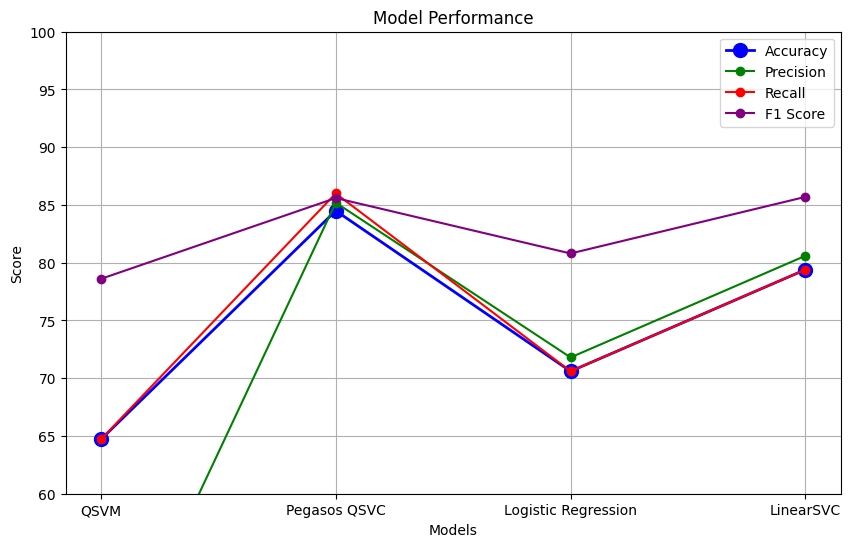

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['QSVM', 'Pegasos QSVC', 'Logistic Regression', 'LinearSVC']

# Accuracy values for each model
accuracy = [64.7, 84.5, 70.6, 79.4]

# Precision values for each model
precision = [41.9, 85.2, 71.8, 80.6]

# Recall values for each model
recall = [64.7, 86.0, 70.6, 79.4]

# F1 Score values for each model
f1_score = [78.6, 85.6, 80.8, 85.7]

# Create the line graph
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy, marker='o', linestyle='-', color='b', label='Accuracy', markersize=10, linewidth=2)
plt.plot(models, precision, marker='o', linestyle='-', color='g', label='Precision')
plt.plot(models, recall, marker='o', linestyle='-', color='r', label='Recall')
plt.plot(models, f1_score, marker='o', linestyle='-', color='purple', label='F1 Score')

# Customize the plot
plt.title('Model Performance')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(loc='best')
plt.ylim(60, 100)  # Set the y-axis range from 0 to 100
plt.grid(True)

# Display the plot
plt.show()
